In [60]:
# 1-1. 패키지 호출
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.keras import layers

print("Tensorflow Version: %s" % tf.__version__)
print("Keras Version: %s" %tf.keras.__version__)

Tensorflow Version: 2.2.0
Keras Version: 2.3.0-tf


In [61]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [62]:
tf.test.gpu_device_name()
tf.config.experimental.list_physical_devices(device_type='GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [63]:
# 2-1. CSV 데이터 읽어오기
import pandas as pd

data = pd.read_csv('C:/Users/tqkqh/Documents/GitHub/Korean_GAN/pre/train/train_gen.csv').astype('float32')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
2,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0


In [64]:
data.shape

(15745, 1024)

In [65]:
# 2-2. 3D Vector 변환

width, height, channel = 32, 32, 1 # 이미지 사이즈 32*32 pixel 흑백

X = data.values
X = X.reshape((X.shape[0], width, height, channel))

print(X.shape)

(15745, 32, 32, 1)


In [66]:
# 2-3. Image Pixel Normalization [0,255] -> [-1,1]  하이퍼볼릭 탄젠트

X = (X - 127.5) / 127.5 

print(X[0])

[[[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 ...

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]

 [[1.]
  [1.]
  [1.]
  ...
  [1.]
  [1.]
  [1.]]]


In [67]:
X[0].shape

(32, 32, 1)

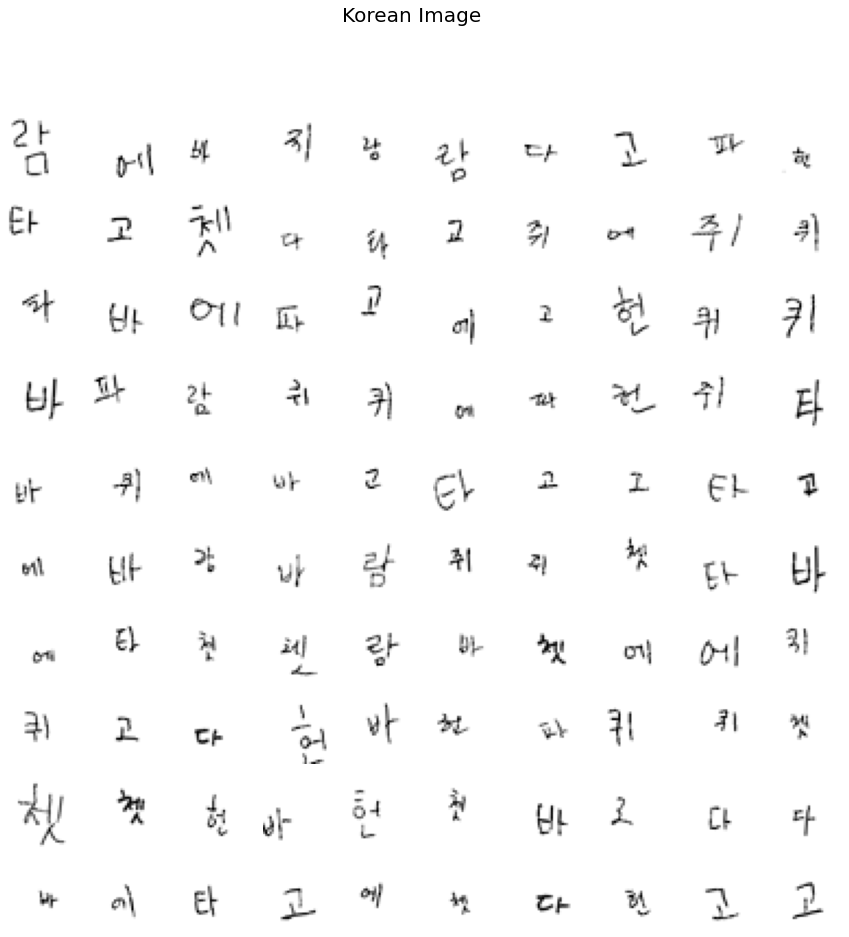

In [68]:
# 2-4. 한글 이미지 시각화
 
plt.figure(figsize=(15,15))
    
i = 1
for image in X:
    plt.subplot(10, 10, i) #(10*10) 총 100칸
    image = image.reshape(width, height)
    plt.imshow(image, cmap='gray') # 흑백 이미지
    plt.axis('off')
    i+=1
    if i > 100: break

plt.suptitle("Korean Image", fontsize = 20)
plt.show()

In [69]:
# 2-5. 학습 데이터 batch 준비

BATCH_SIZE = 64

# Input dataset + image randum shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(X.shape[0]).batch(BATCH_SIZE)

print(train_dataset)

<BatchDataset shapes: (None, 32, 32, 1), types: tf.float32>


In [70]:
# 3-1. Generator 모델 네트워크 구성

def build_generator_model():
    model = tf.keras.Sequential() # Keras 모델 생성

    model.add(layers.Dense(8*8*16, input_dim=100, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(8*8*32, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(8*8*64, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Dense(8*8*128, use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Resahpe (8*8)
    model.add(layers.Reshape((8, 8, 128)))  
    model.add(layers.Conv2DTranspose(128, (5, 5), 
                                    strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization()) 
    model.add(layers.LeakyReLU())
    
    # (8*8) -> (16*16)
    model.add(layers.Conv2DTranspose(64, (5, 5), 
                                    strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # (16*16) -> (32*32)
    model.add(layers.Conv2DTranspose(1, (5, 5), 
                                    strides=(2, 2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)

    return model

In [71]:
# 3-2. 생성자 모델 생성

generator = build_generator_model()
generator.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 1024)              102400    
_________________________________________________________________
batch_normalization_56 (Batc (None, 1024)              4096      
_________________________________________________________________
leaky_re_lu_64 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_32 (Dense)             (None, 2048)              2097152   
_________________________________________________________________
batch_normalization_57 (Batc (None, 2048)              8192      
_________________________________________________________________
leaky_re_lu_65 (LeakyReLU)   (None, 2048)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 4096)            

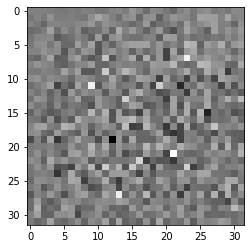

In [72]:
# 3-3. 학습되지 않은 생성자 모델이 만든 이미지

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [73]:
# 4-1. Discriminator 모델 네트워크 구성

def build_discriminator_model():

    model = tf.keras.Sequential()
    model.add(layers.Conv2D(32, (5, 5), strides=2, padding='same', 
                       input_shape=[32, 32, 1])) # input image size
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(64, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1))
    
    return model

In [74]:
# 4-2. 판별자 모델 생성

discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 32)        832       
_________________________________________________________________
leaky_re_lu_70 (LeakyReLU)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
leaky_re_lu_71 (LeakyReLU)   (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 128)       

In [75]:
# 4-3. 학습되지 않은 판별자의 결과
#가짜는 0에 가깝게 진짜는 1에가깝게
predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[-4.9889706e-05]], shape=(1, 1), dtype=float32)


In [76]:
# 5-1. Optimizer 생성

# 생성자용
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
# 판별자용
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [77]:
# 5-2. BinaryCrossentropy for minMax 손실함수

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [78]:
# 5-2. Generator Loss 함수

# 생성자 모델 목표 : 
# 판별자 모델이 가짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # 1과 가짜 이미지를 판별 값 비교

In [79]:
# 5-3. Discriminator Loss 함수

# 판별자 모델 목표 :
# 1. 진짜 이미지를 판별했을 때 판별 값이 1에 가까워지도록
# 2. 가짜 이미지를 판별했을 때 판별 값이 0에 가까워지도록
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) # 1. 1과 진짜 이미지 판별 값 비교
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # 2. 0과 가짜 이미지 판별 값 비교
    total_loss = real_loss + fake_loss
    return total_loss

In [80]:
# 6-1. 학습 값 설정

EPOCHS = 100
noise_dim = 100

In [81]:
@tf.function
def train_step(images):
    # 생성자 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True) # 진짜 이미지를 봤을 때의 판별 값
        fake_output = discriminator(generated_images, training=True) # 가짜 이미지를 봤을 때의 판별 값

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [82]:
# 6-4. 테스트 노이즈 시각화 함수

test_noise = tf.random.normal([100, noise_dim]) # 학습 시각화를 위한 테스트 노이즈

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5 * images + 0.5
    
    plt.figure(figsize=(11,11))
    
    i = 1
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        i+=1

    plt.suptitle("Generated Images on EPOCH: %s" % epoch, fontsize = 25)
  #  plt.show()
    plt.tight_layout()
    plt.savefig('./test2/epoch_%d.png' % epoch)
                #)

In [83]:
# 6-4. 학습 코드

def train(dataset, epochs):
    for epoch in range(epochs): # 전체 데이터 학습 반복 횟수(300)

        for image_batch in dataset: # batch 학습(64)
            train_step(image_batch)
        print("%s epochs trained" % epoch)
       
        
        if epoch % 5 == 0: # 5번째 에포크 마다 이미지 시각화
            show_generated_images(epoch) 
            
            

0 epochs trained
1 epochs trained
2 epochs trained
3 epochs trained
4 epochs trained
5 epochs trained
6 epochs trained
7 epochs trained
8 epochs trained
9 epochs trained
10 epochs trained
11 epochs trained
12 epochs trained
13 epochs trained
14 epochs trained
15 epochs trained
16 epochs trained
17 epochs trained
18 epochs trained
19 epochs trained
20 epochs trained
21 epochs trained
22 epochs trained
23 epochs trained
24 epochs trained
25 epochs trained
26 epochs trained
27 epochs trained
28 epochs trained
29 epochs trained
30 epochs trained
31 epochs trained
32 epochs trained
33 epochs trained
34 epochs trained
35 epochs trained
36 epochs trained
37 epochs trained
38 epochs trained
39 epochs trained
40 epochs trained
41 epochs trained
42 epochs trained
43 epochs trained
44 epochs trained
45 epochs trained
46 epochs trained
47 epochs trained
48 epochs trained
49 epochs trained
50 epochs trained
51 epochs trained
52 epochs trained
53 epochs trained
54 epochs trained
55 epochs trained
56

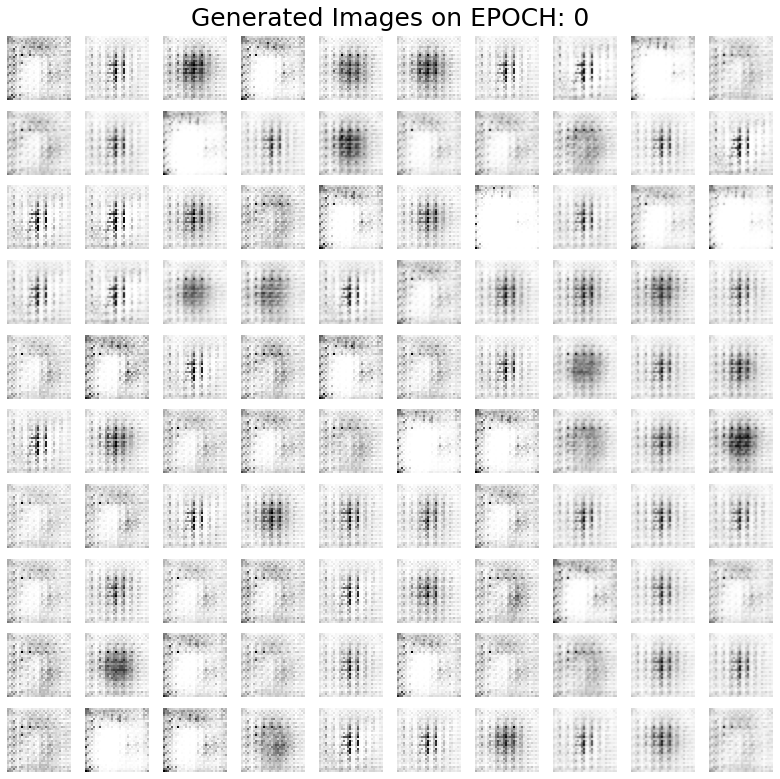

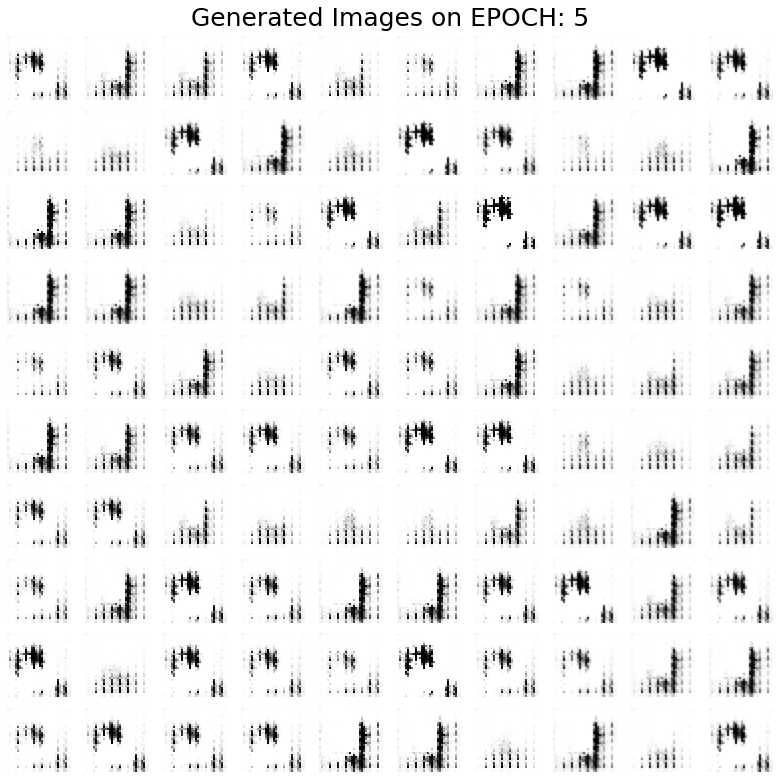

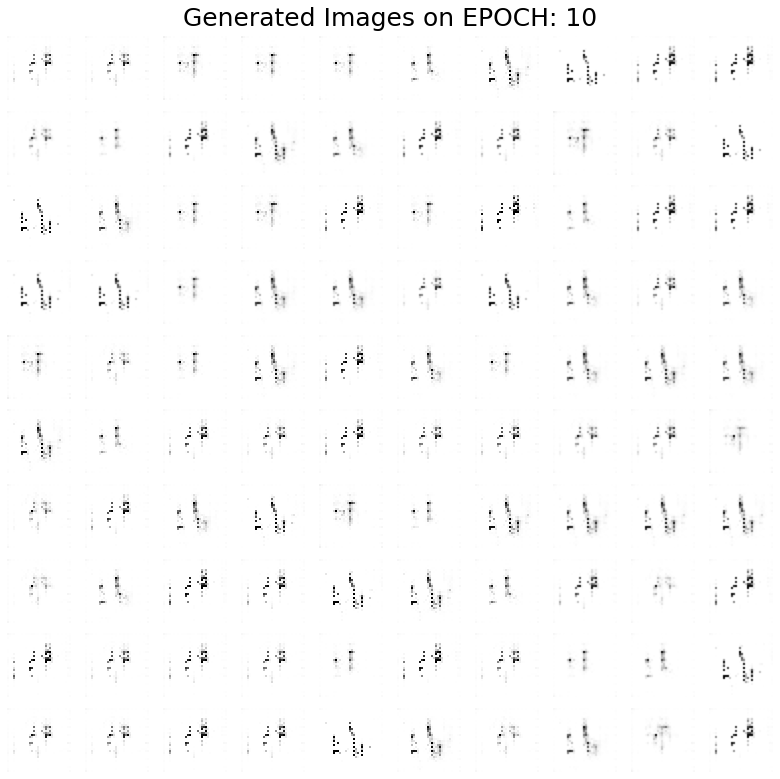

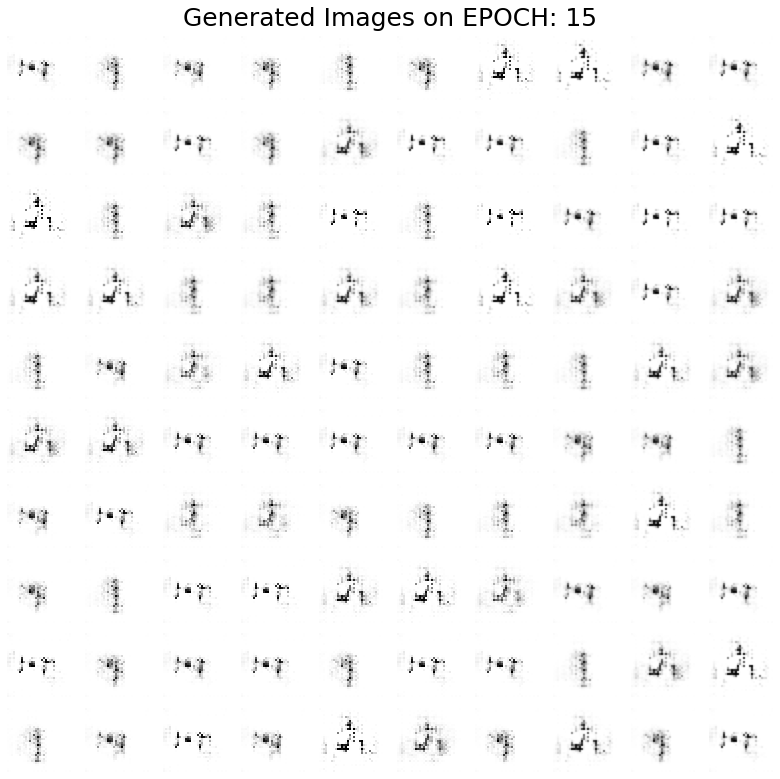

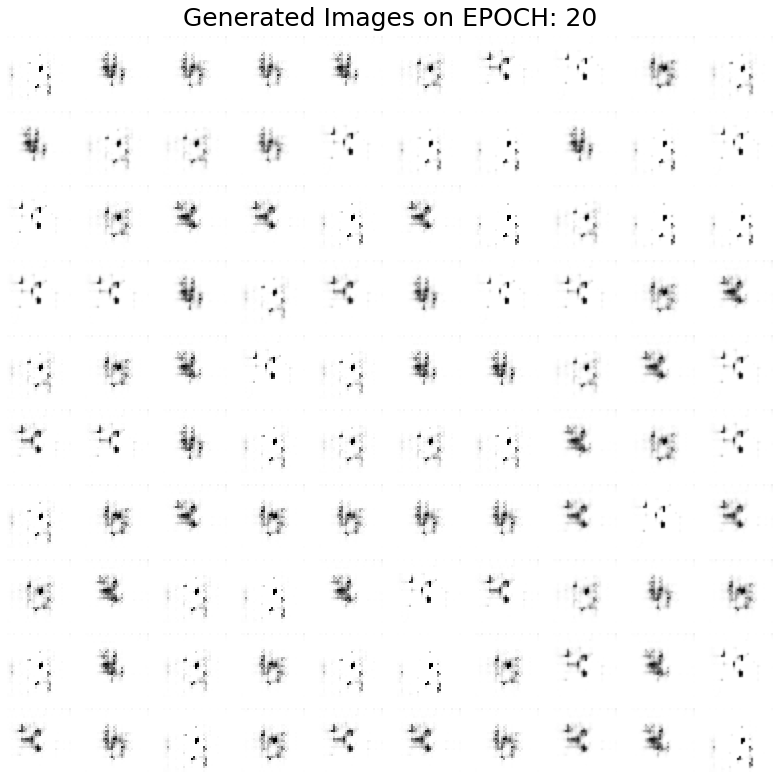

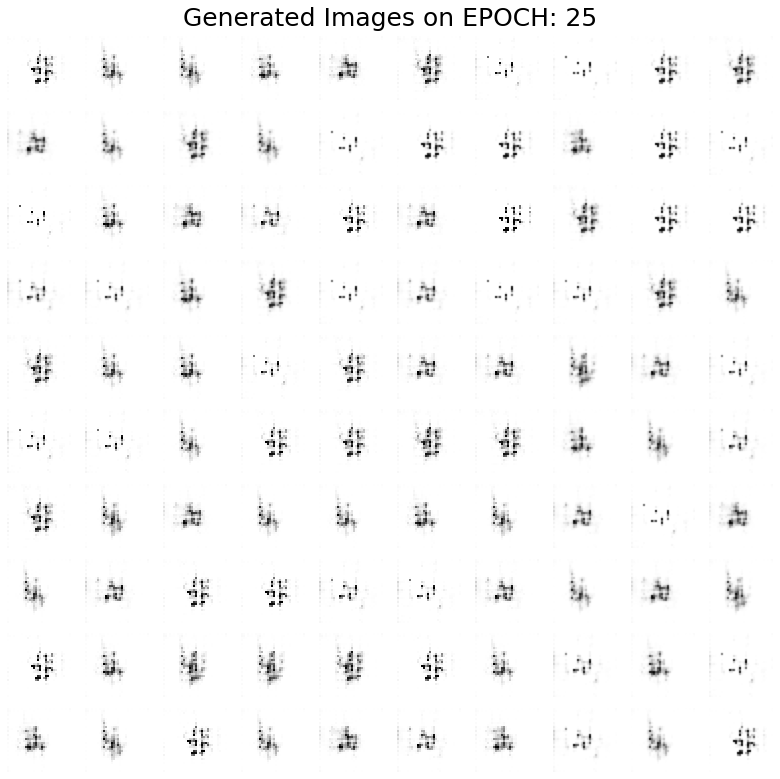

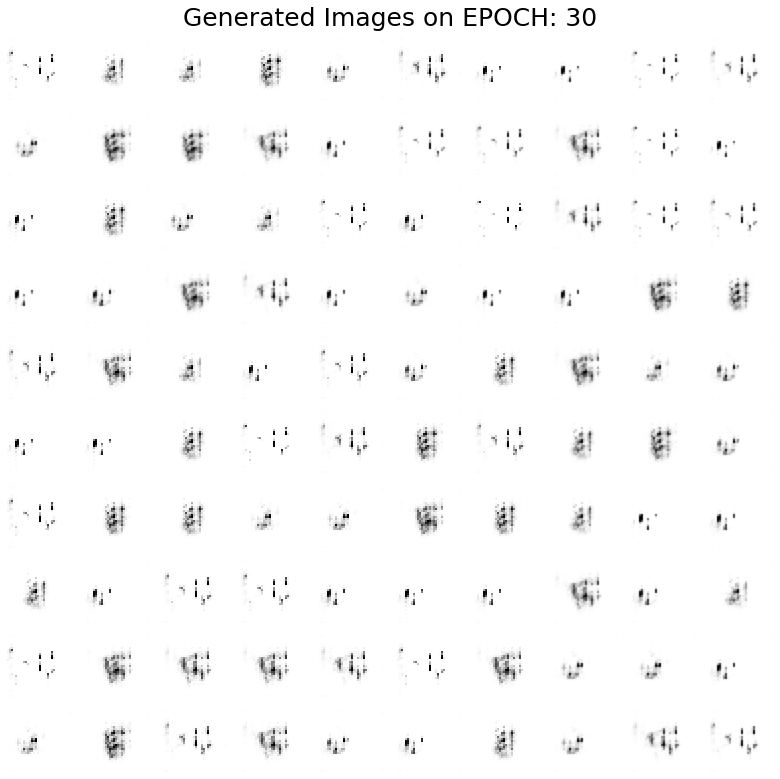

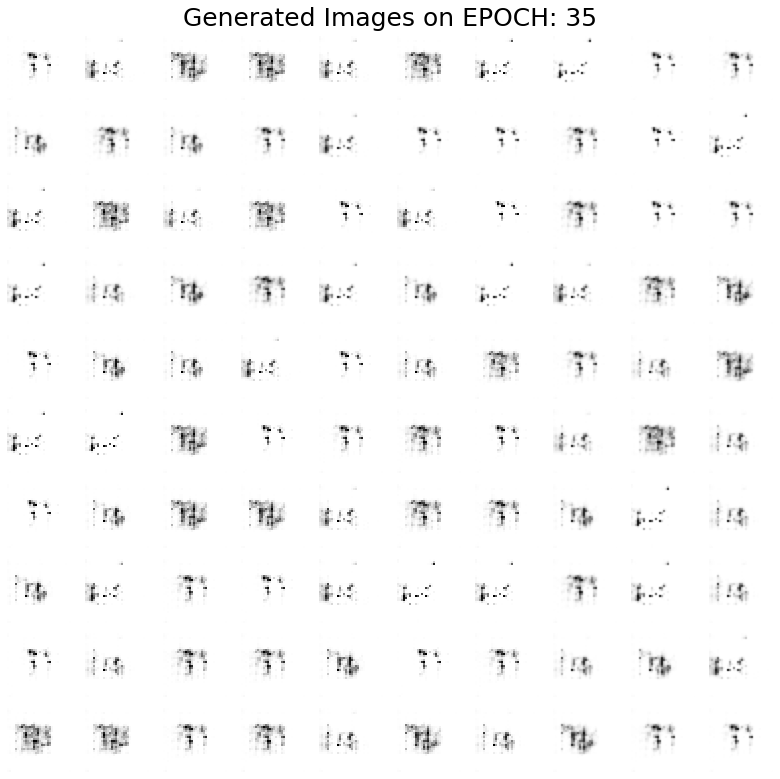

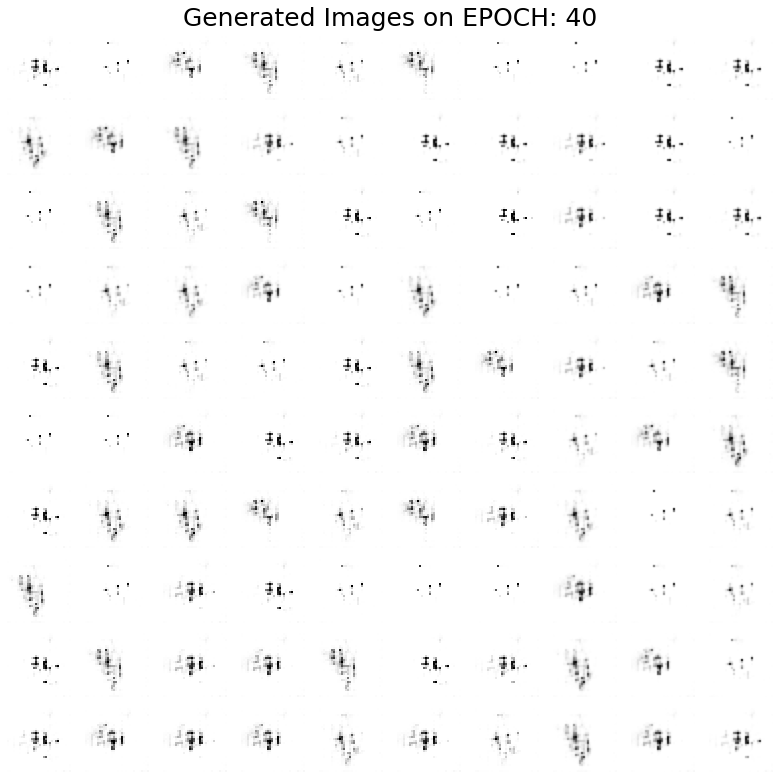

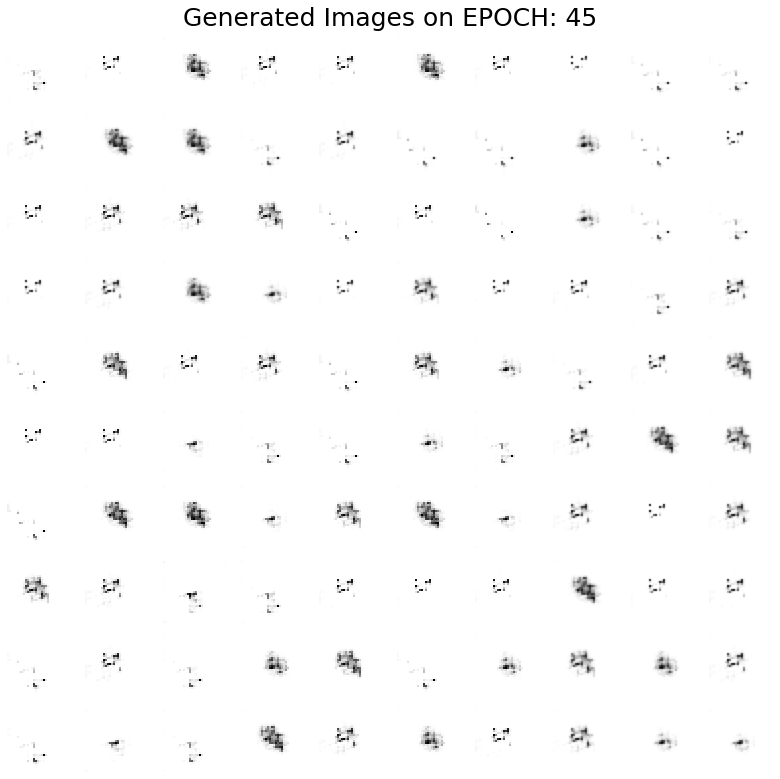

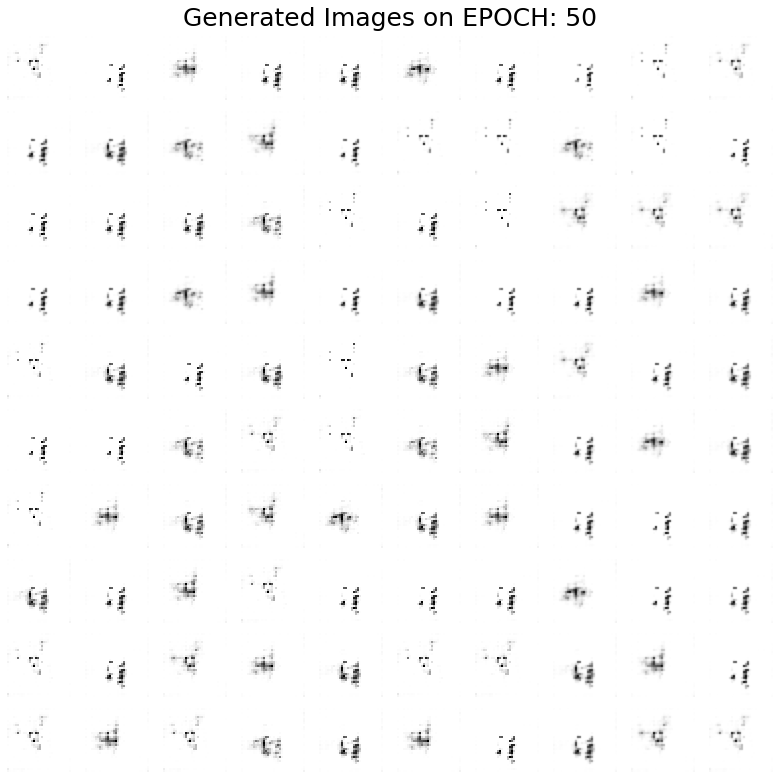

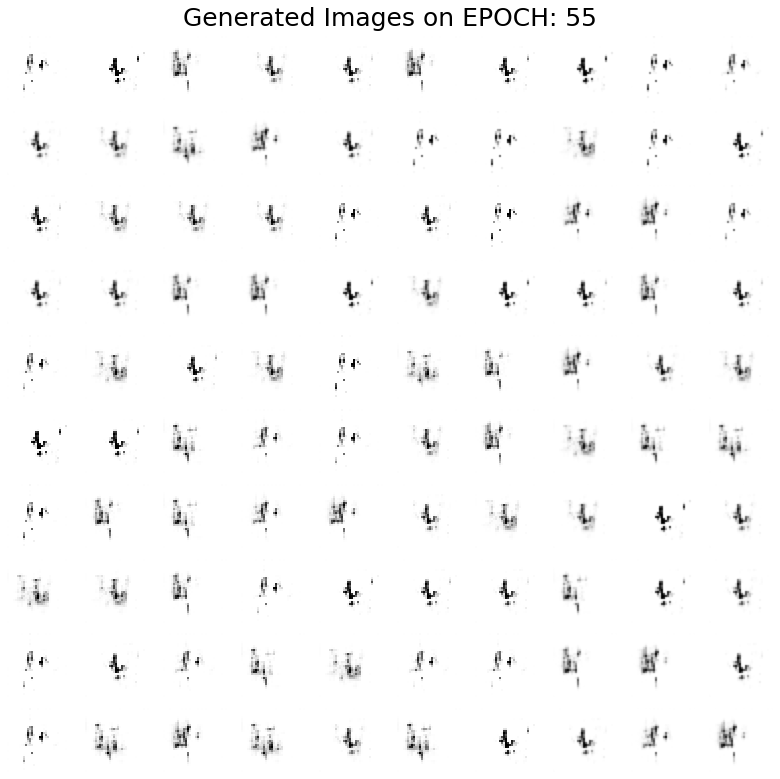

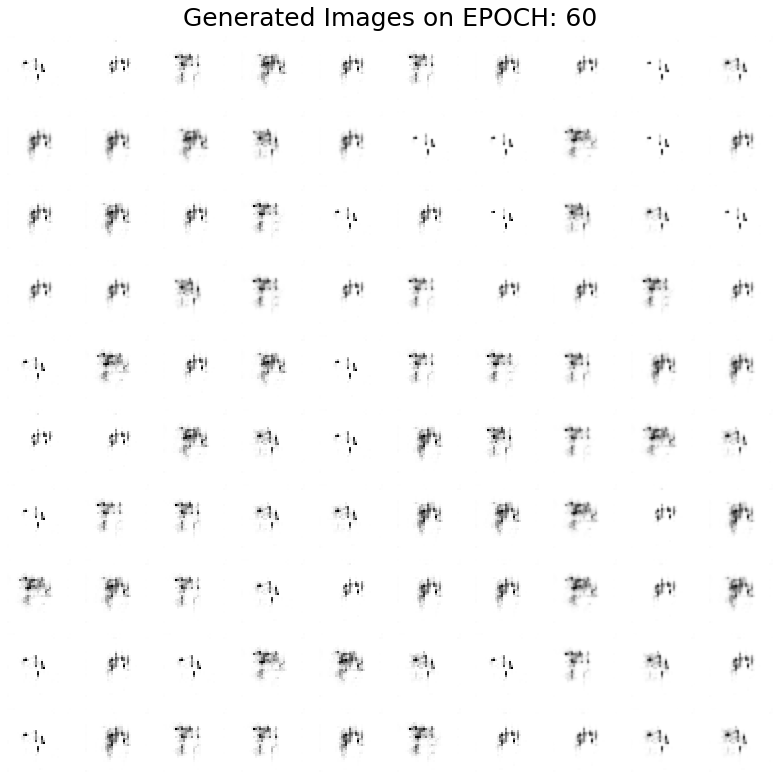

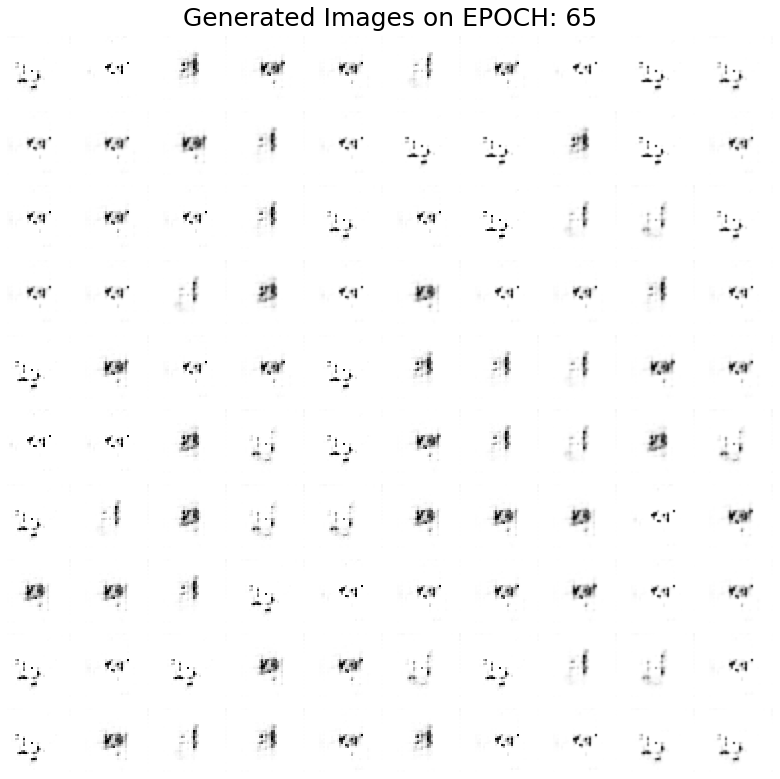

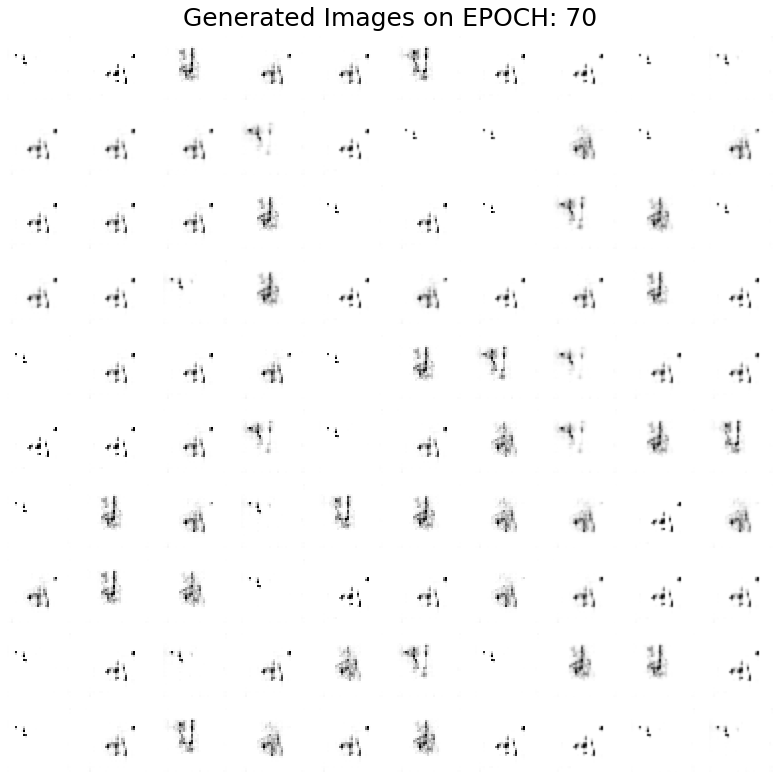

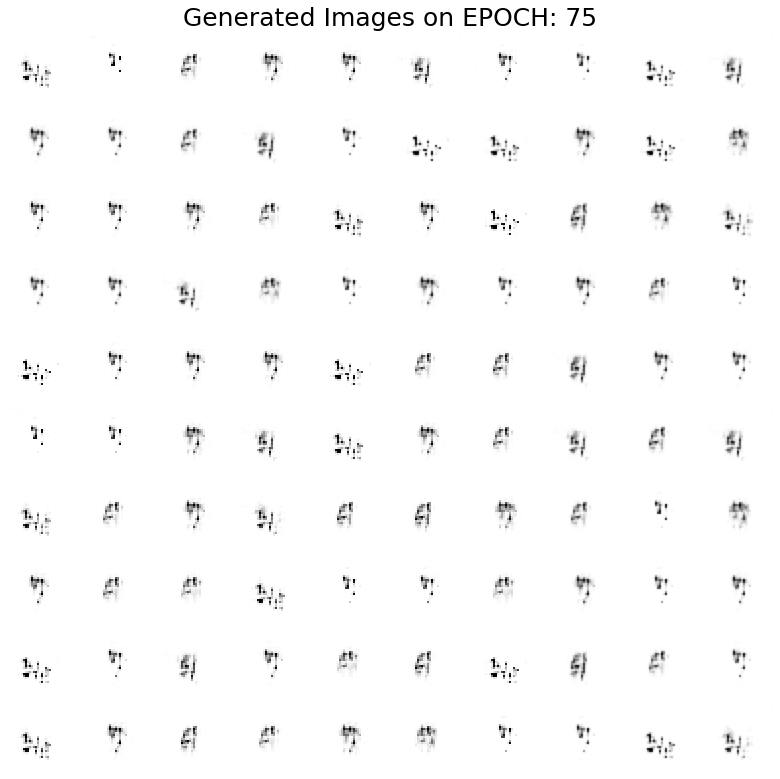

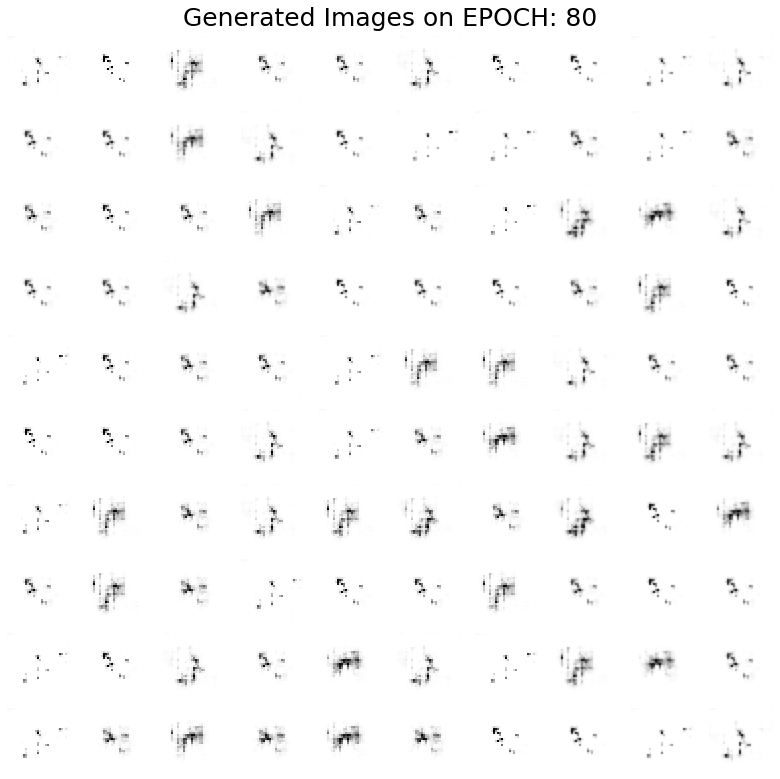

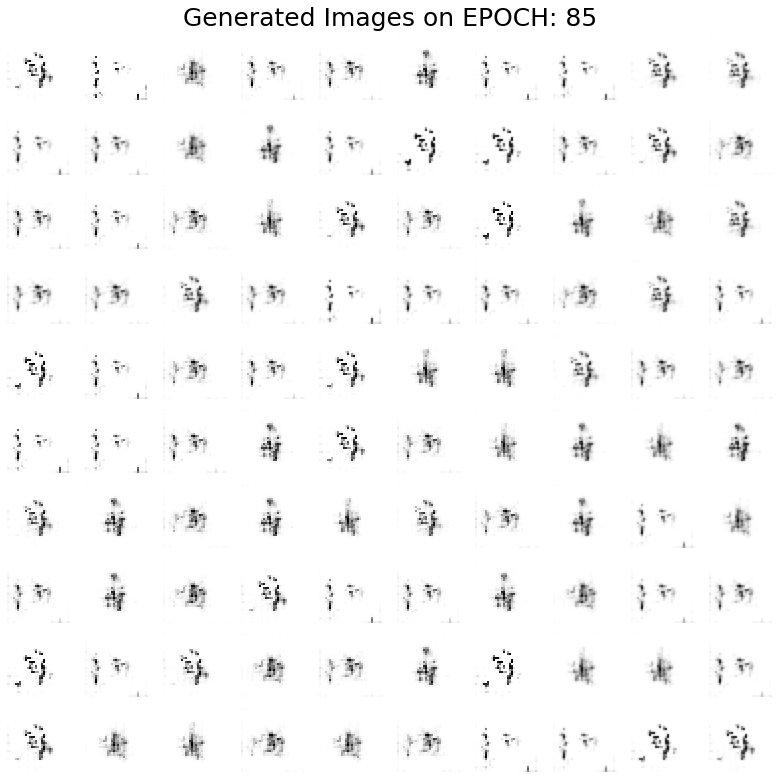

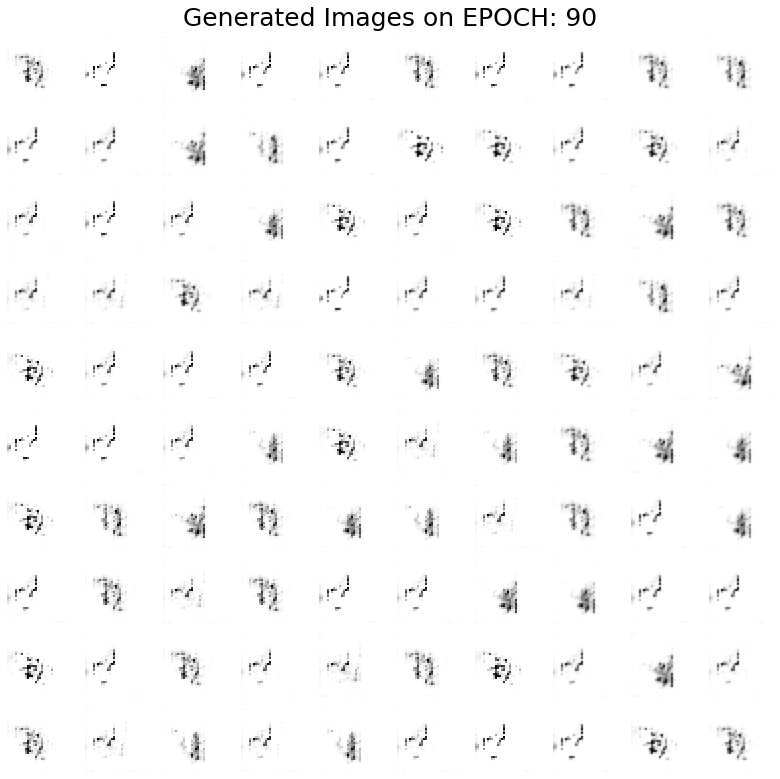

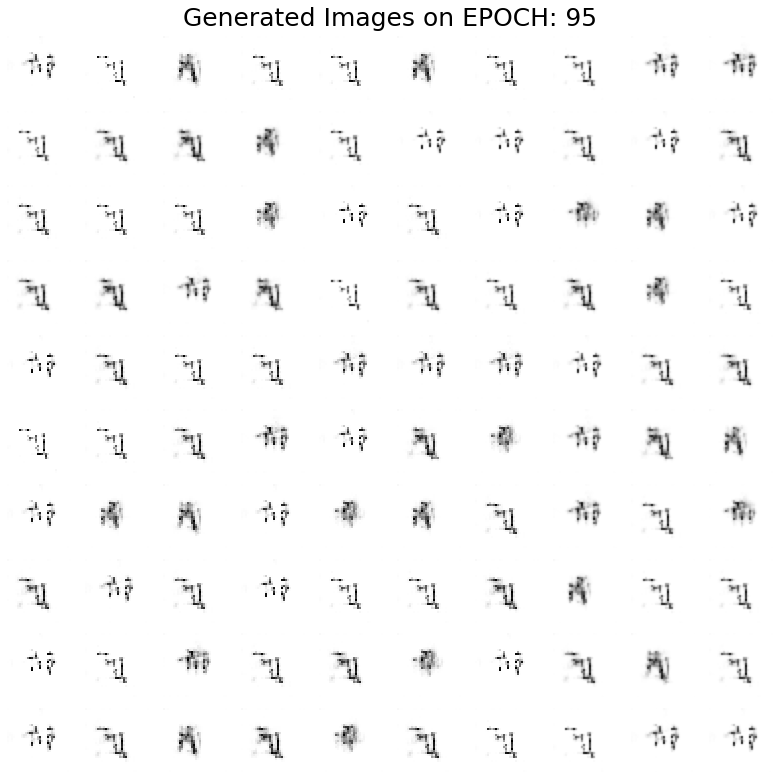

In [84]:
# 6-5. 학습 시작!

train(train_dataset, EPOCHS)